In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm
import pandas as pd
import copy

In [ ]:
P_0_matrix=np.array([[0.1,0.9,0,0,0],
                   [0.1,0,0.9,0,0],
                   [0.1,0,0,0.9,0],
                   [0.1,0,0,0,0.9],
                   [0.1,0,0,0,0.9]])
P_0_matrix


array([[0.1, 0.9, 0. , 0. , 0. ],
       [0.1, 0. , 0.9, 0. , 0. ],
       [0.1, 0. , 0. , 0.9, 0. ],
       [0.1, 0. , 0. , 0. , 0.9],
       [0.1, 0. , 0. , 0. , 0.9]])

In [ ]:
P_1_matrix=np.array([[1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0]])
P_1_matrix

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
action_space=[0,1]
state_space=[0,1,2,3,4]
A=0.9
reward_matrix=[[A**1,0],[A**2,0],[A**3,0],[A**4,0],[A**5,0]]
N=100
M=20
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [ ]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [ ]:
Q=copy.deepcopy(reward_matrix)

In [ ]:


def act(Q_values,epsilon,state):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[state])
  return action

In [ ]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]

In [ ]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1

In [ ]:
for i in range(1,500001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  alpha=1/(1+(i/500))
  beta=1/(1+(i*np.log(i)/500))
  action_sum_flag=0

  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q,epsilon,current_state[index])
      action_sum+=action

      if action_sum_flag==1:
        continue
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      if action==1:
          Q[current_state[index]][action]=(1-alpha)*(Q[current_state[index]][action])+alpha*(reward+max(Q[new_state])-(np.array(Q).sum())/10)
      else:
        Q[current_state[index]][action]=(1-alpha)*(Q[current_state[index]][action])+alpha*(reward+subsidy+max(Q[new_state])-(np.array(Q).sum())/10)
      current_state[index]=new_state
      reward_sum+=reward
      if action_sum==M:
        action_sum_flag=1
      #print(x)
  # print(i)
  #print(reward_sum)

  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  epsilon=epsilon*gamma
  if epsilon<=0.01:
    epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








Text(0.5, 1.0, 'Subsidy vs Steps for Restart Example')

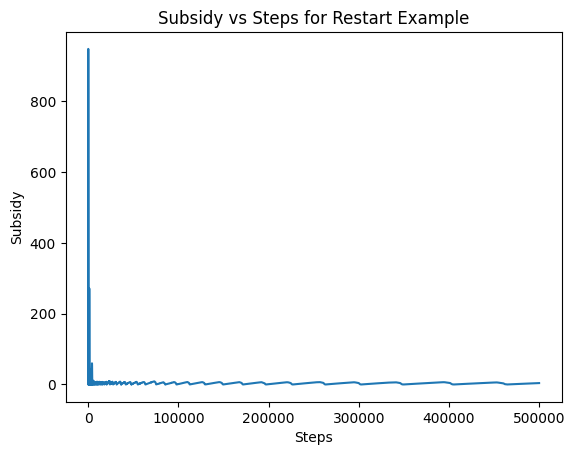

In [ ]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Restart Example')

In [ ]:
df=pd.DataFrame(rewards)


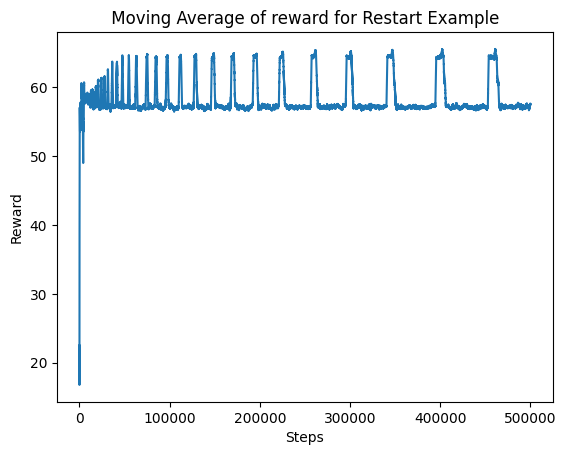

In [ ]:
plt.plot(df[0].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Restart Example ')
plt.savefig('Moving Average of reward for Restart Example.png')

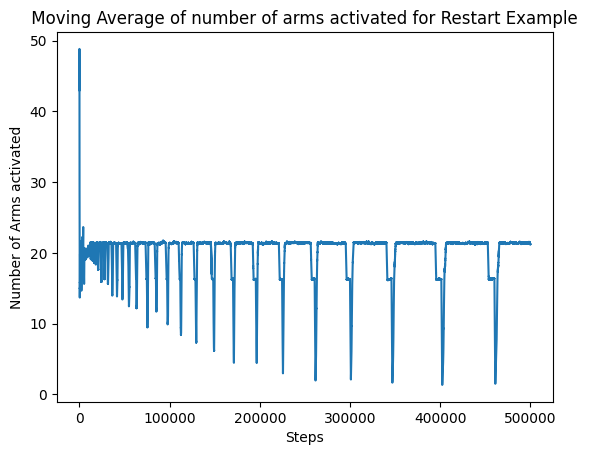

In [ ]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Restart Example ')
plt.savefig('Moving Average of number of arms activated for Restart Example.png')

In [ ]:
for x in Q:
  print(x[1]-x[0])

-4.093431719751505
-3.044300032828776
-1.938993217254379
0.7006044100984594
2.25599878024987


In [ ]:
#using learnt indices
current_state=[0 for _ in range(N)]
actual_whittle_indexes=[-0.9,-0.73,-0.5,-0.26,-0.01]
reward_sums_alt_index=[]
reward_sums_whittle_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q[current_state[index]][1]-Q[current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)


In [ ]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Restart Example ')

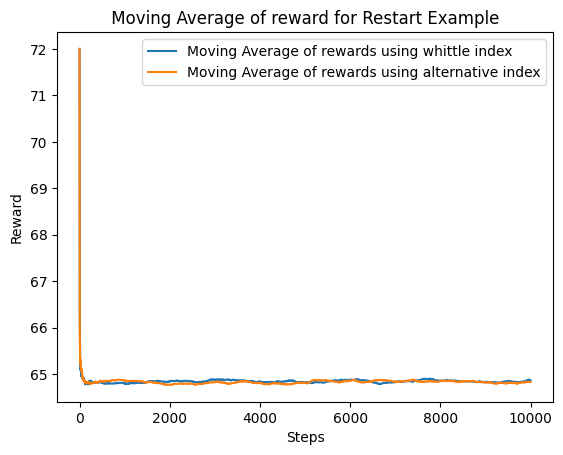

In [ ]:
df=pd.DataFrame()
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Restart Example ')